In [47]:
import gym
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.activations import relu, linear
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import pickle

## Условия окружения

LunarLander-v2
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Инициализируем окружение

In [2]:
env = gym.make('LunarLander-v2')

/home/obi-1-konobe/projects/mag/ml/task_6/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Состояния описываются 8 параметрами

In [3]:
env.observation_space

Box(8,)

Существует 4 варианта действий

In [4]:
env.action_space.n

4

Инициализируем гиперпараметры

In [27]:
lr = 0.0001
state_size = 8
n_actions = 4
exp_bufer = list()
epsilon = 1
min_epsilon = 0.1
gamma = 0.99
batch_size = 100

Инициализируем нейронную сеть

In [28]:
model = Sequential()
model.add(Dense(256, input_dim=state_size, activation=relu))
model.add(Dense(128, activation=relu))
model.add(Dense(n_actions, activation=linear))
model.compile(loss='mse', optimizer=adam(lr=lr))

Функция выбора действия по состоянию

In [29]:
def get_action(state):
    # exploartion vs explotation
    exploration_explotation =  random.random()
    if exploration_explotation < epsilon:
        random_action = env.action_space.sample()
        return random_action
    best_action = np.argmax(model.predict(state)[0])
    return best_action

Функция обновления весов сети

In [30]:
def update_weights():
    # набирвем батч из буфера
    batch = random.sample(exp_bufer, batch_size)
    # рассчитываем значения Q-функции 
    states = np.array([i[0] for i in batch])
    actions = np.array([i[1] for i in batch])
    rewards = np.array([i[2] for i in batch])
    next_states = np.array([i[3] for i in batch])
    dones = np.array([i[4] for i in batch])
    
    states = np.squeeze(states)
    next_states = np.squeeze(next_states)
    
    targets = rewards + gamma*(np.amax(model.predict_on_batch(next_states), axis=1))*(1-dones)
    # подставляем новые значения Q-функции
    targets_full = model.predict_on_batch(states)
    ind = np.array([i for i in range(batch_size)])
    targets_full[[ind], [actions]] = targets
    # обновляем веса сети
    model.fit(states, targets_full, epochs=1, verbose=0)

Запускаем 10 эпизодов со случайными действиями для первичного заполнения буфера

In [31]:
for i in range(10):
    done = False
    state = env.reset()
    while not done:
        state = np.reshape(state, (1, 8))
        random_action = env.action_space.sample()
        env.render()
        next_state, reward, done, info = env.step(random_action)
        next_state = np.reshape(next_state, (1, 8))
        exp_bufer.append((state, random_action, reward, next_state, done))
        state = next_state
    
env.close()
print(len(exp_bufer))

1042


Тренируем нейронную сеть

In [32]:
episodes_score = list()
counter = 0
for episode in range(2000):
    state = env.reset()
    state = np.reshape(state, (1, state_size))
    cumulative_rewards = 0
    max_steps = 2000
    for i in range(max_steps):
        # выбираем действие
        action = get_action(state)
        # получаем новые параметры и сохраняем их в буфер
        env.render()
        next_state, reward, done, info = env.step(action)
        cumulative_rewards += reward
        next_state = np.reshape(next_state, (1, state_size))
        exp_bufer.append((state, action, reward, next_state, done))
        state = next_state
        # обновляем веса
        update_weights()
        # если эпизод закончился
        if done:
            print(f'episode {episode} score {cumulative_rewards} counter {counter}')
            # уменьшаем exploration
            if epsilon > min_epsilon:
                epsilon -= 0.01
            break
    
    episodes_score.append(cumulative_rewards)
    if cumulative_rewards < 0:
        counter = 0
        continue
    # если последние 100 эпизадов закончились +0, то завершаем обучение
    counter += 1
    if counter >= 150:
        print('finish')
        break


episode 0 score -186.71530694317107 counter 0
episode 1 score -323.99194618411934 counter 0
episode 2 score -81.53286254871318 counter 0
episode 3 score -396.0114716718113 counter 0
episode 4 score -425.3404799945568 counter 0
episode 5 score -76.3257119748026 counter 0
episode 6 score -101.92745036066127 counter 0
episode 7 score -153.24099808979093 counter 0
episode 8 score -307.13943220035776 counter 0
episode 9 score -199.8420904781404 counter 0
episode 10 score -214.68472375556766 counter 0
episode 11 score -185.61608170655495 counter 0
episode 12 score -73.01626973172705 counter 0
episode 13 score -73.16716289400131 counter 0
episode 14 score -187.83291105177696 counter 0
episode 15 score -191.30161555129052 counter 0
episode 16 score -72.13938604326012 counter 0
episode 17 score -171.5826628479191 counter 0
episode 18 score -78.57443409830762 counter 0
episode 19 score -154.52619435058824 counter 0
episode 20 score -122.86221680177195 counter 0
episode 21 score -126.580713119508

episode 176 score 265.8536896213755 counter 5
episode 177 score 130.2375777718387 counter 6
episode 178 score 122.44855734722734 counter 7
episode 179 score 293.0576856307008 counter 8
episode 180 score 174.91686261757377 counter 9
episode 181 score 162.34764607363317 counter 10
episode 182 score -39.36699085475673 counter 11
episode 183 score 246.7914388173465 counter 0
episode 184 score 59.90175932747874 counter 1
episode 185 score 219.8134174215531 counter 2
episode 186 score 206.26618683700252 counter 3
episode 187 score 225.71615116093767 counter 4
episode 188 score 278.3636230247141 counter 5
episode 189 score 178.6049453680934 counter 6
episode 190 score 146.37634911304556 counter 7
episode 191 score 156.32725091228195 counter 8
episode 192 score 292.20943528259744 counter 9
episode 193 score 189.98388119914193 counter 10
episode 194 score 209.57474647823676 counter 11
episode 195 score 182.27137181503406 counter 12
episode 196 score 288.96449007195326 counter 13
episode 197 sco

episode 350 score 218.36773671262512 counter 35
episode 351 score 275.8092714775758 counter 36
episode 352 score 264.6718502300529 counter 37
episode 353 score 245.45227258863758 counter 38
episode 354 score 241.43048253590297 counter 39
episode 355 score 206.5924226705925 counter 40
episode 356 score 214.94462251410826 counter 41
episode 357 score 213.86251000336821 counter 42
episode 358 score 216.9853895835324 counter 43
episode 359 score 203.4909035512104 counter 44
episode 360 score 262.6166625160465 counter 45
episode 361 score 280.20806457055835 counter 46
episode 362 score 249.81435196626666 counter 47
episode 363 score 37.96791088989795 counter 48
episode 364 score 269.2862209103524 counter 49
episode 365 score 255.46349348796508 counter 50
episode 366 score 219.40971430611978 counter 51
episode 367 score 204.64935260542876 counter 52
episode 368 score 238.00351633349337 counter 53
episode 369 score 279.03150861286997 counter 54
episode 370 score 222.96261193961334 counter 55


episode 524 score 275.97445705464395 counter 51
episode 525 score 240.73066113094671 counter 52
episode 526 score 241.57252083588963 counter 53
episode 527 score 245.51178211081694 counter 54
episode 528 score 289.18181911079614 counter 55
episode 529 score 255.49506007369672 counter 56
episode 530 score 258.1139258219903 counter 57
episode 531 score 227.49624316638653 counter 58
episode 532 score 282.4525951672813 counter 59
episode 533 score 287.21509670301083 counter 60
episode 534 score 287.2092862452923 counter 61
episode 535 score 269.69455624854686 counter 62
episode 536 score 268.1313512188276 counter 63
episode 537 score 232.60834414870232 counter 64
episode 538 score 248.9421829046113 counter 65
episode 539 score 67.49792663857914 counter 66
episode 540 score 214.65114791529453 counter 67
episode 541 score 255.89771247739506 counter 68
episode 542 score 255.5567058739877 counter 69
episode 543 score 157.72210474706364 counter 70
episode 544 score 208.653612244949 counter 71
e

episode 697 score 285.37341295457935 counter 134
episode 698 score 293.4072510819867 counter 135
episode 699 score 19.884949743244434 counter 136
episode 700 score 197.97258282205672 counter 137
episode 701 score 273.53032343187147 counter 138
episode 702 score 238.03608743250615 counter 139
episode 703 score 249.94929873620177 counter 140
episode 704 score 108.73582639592647 counter 141
episode 705 score 242.5457481046694 counter 142
episode 706 score 261.37980734815824 counter 143
episode 707 score 239.07987151124257 counter 144
episode 708 score 264.15744507003956 counter 145
episode 709 score 250.43392987627948 counter 146
episode 710 score 267.9272698712491 counter 147
episode 711 score 267.7571162271658 counter 148
episode 712 score 38.131970108693 counter 149
finish


In [33]:
env.close()

Кривая обучения

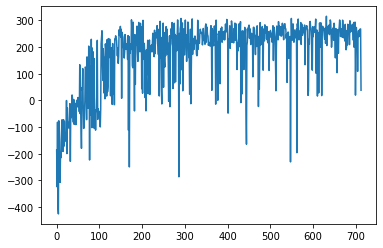

In [34]:
plt.plot(episodes_score)
plt.show()

Тестируем модель

In [35]:
test_score = list()
for i in range(100):
    done = False
    state = env.reset()
    score = 0
    while not done:
    
        state = np.reshape(state, (1, 8))
        action = np.argmax(model.predict(state)[0])
        env.render()
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    test_score.append(score)
env.close()

Кривая теста

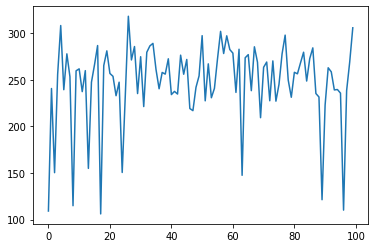

In [36]:
plt.plot(test_score)
plt.show()

Гистограмма

In [37]:
a = len([x for x in test_score if x < 0])
b = len([x for x in test_score if 0 <= x < 100])
c = len([x for x in test_score if 100 <= x < 200])
d = len([x for x in test_score if x > 200])

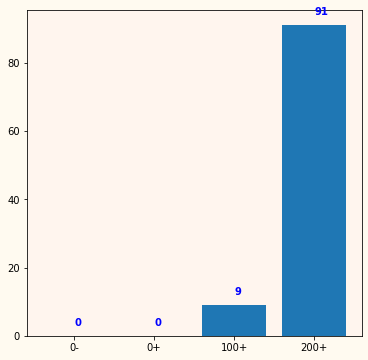

In [46]:
x = ['0-', '0+', '100+', '200+']
y = [a, b, c, d]

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(6)
fig.set_figheight(6)

for i, v in enumerate(y):
    ax.text(i, v + 3, str(v), color='blue', fontweight='bold')

plt.show()

91% прилунений закончились удачно (>200)

In [49]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)